In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from rubin_sim.utils import calcSeason, ddf_locations
from scipy.optimize import minimize, basinhopping


In [2]:
# Can I make a simple alternative to Gurobi for my schedule optimization?

In [3]:
# If my free parameter vector is the length of my total number of available observations, then I can make the
# values the index where they go

# multiply by a mask vector, so anything that 

In [4]:
class Cumulative_diff_sq(object):
    
    def __init__(self, mask=1, desired=None):
        self.mask = mask
        self.desired = desired
        
    def cumulative_sched(self, x0):
        sched = self.desired * 0
        indx = np.round(x0).astype(int)
        indx[np.where(indx < 0)] = 0
        indx[np.where(indx >= self.desired.size)] = self.desired.size -1
        sched[indx] = 1
        sched *= self.mask
        cumulative_sched = np.cumsum(sched)
        return cumulative_sched
    
    
    def __call__(self, x0):
    
        """
        Parameters
        ----------

        desired : `np.array`
            An array of the desired cummulative distribution
        """
        
        cs = self.cumulative_sched(x0)
        # Compute the chi-squared of our resulting schedule and 
        # the desired schedule
        #result = np.sum((self.desired - cs)**2)
        
        # Let's do maximum abs deviation
        result = np.max(np.abs(self.desired - cs))

        return result

In [5]:
ddf_name = "ELAISS1"
ddfs = ddf_locations()
ddf_RA = ddfs[ddf_name][0]

ddf_data = np.load('ddf_grid.npz')
ddf_grid = ddf_data['ddf_grid'].copy()
sun_limit=np.radians(-18)
airmass_limit=2.1
sky_limit=21.75
season_frac = 0.2
sequence_limit=286

# XXX-- double check that I got this right
ack = ddf_grid['sun_alt'][0:-1] * ddf_grid['sun_alt'][1:]
night = np.zeros(ddf_grid.size, dtype=int)
night[np.where((ddf_grid['sun_alt'][1:] >= 0) & (ack < 0))] += 1
night = np.cumsum(night)
ngrid = ddf_grid['mjd'].size


In [6]:
night

array([   0,    0,    0, ..., 3653, 3653, 3653])

In [7]:
 # set a sun mask
sun_mask = np.ones(ngrid, dtype=int)
sun_mask[np.where(ddf_grid['sun_alt'] >= sun_limit)] = 0

airmass_mask = np.ones(ngrid, dtype=int)
airmass_mask[np.where(ddf_grid['%s_airmass' % ddf_name] >= airmass_limit)] = 0

sky_mask = np.ones(ngrid, dtype=int)
sky_mask[np.where(ddf_grid['%s_sky_g' % ddf_name] <= sky_limit)] = 0
sky_mask[np.where(np.isnan(ddf_grid['%s_sky_g' % ddf_name]) == True)] = 0

In [8]:
potential_nights = np.unique(night * sun_mask * airmass_mask * sky_mask)

In [9]:
# prevent a repeat sequence in a night
unights, indx = np.unique(night, return_index=True)
night_mjd = ddf_grid['mjd'][indx]
# The season of each night
night_season = calcSeason(ddf_RA, night_mjd)

raw_obs = np.ones(unights.size)
# take out the ones that are out of season
season_mod = night_season % 1
out_season = np.where((season_mod < season_frac) | (season_mod > (1.-season_frac)))
raw_obs[out_season] = 0
cumulative_desired = np.cumsum(raw_obs)
cumulative_desired = cumulative_desired/cumulative_desired.max()*sequence_limit
grad = np.diff(cumulative_desired)

# Makes it go blazing fast agian, that's for sure!
#cumulative_desired = np.round(cumulative_desired)

night_mask = unights*0
night_mask[potential_nights] = 1

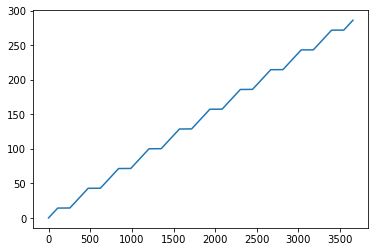

In [10]:
plt.plot(unights,cumulative_desired )

In [11]:
# Let's make an initial guess that we should schedule where the gradiant is positive and the mask is 1
potential_indx = np.where((np.concatenate([np.array([1]),grad]) > 0) & (night_mask > 0))[0]

# Let's just uniformly sample out potential_indx array to construct our initial guess
x0 = potential_indx[np.linspace(0,potential_indx.size-1, num=sequence_limit).astype(int)]

In [12]:
cumulative_desired, potential_indx.shape

(array([1.30534003e-01, 2.61068005e-01, 3.91602008e-01, ...,
        2.85738932e+02, 2.85869466e+02, 2.86000000e+02]),
 (1625,))

In [13]:
x0

array([   0,    5,   11,   17,   22,   33,   39,   44,   50,   64,   69,
         75,   91,   97,  102,  257,  273,  278,  284,  290,  303,  309,
        315,  328,  333,  339,  345,  350,  360,  366,  371,  377,  387,
        393,  398,  404,  416,  421,  427,  433,  447,  453,  459,  630,
        635,  641,  656,  661,  667,  673,  685,  691,  697,  703,  714,
        720,  726,  731,  741,  747,  752,  758,  768,  773,  779,  785,
        798,  803,  809,  815,  830,  836,  988,  993,  999, 1015, 1021,
       1026, 1041, 1047, 1052, 1058, 1070, 1075, 1081, 1087, 1098, 1103,
       1109, 1115, 1124, 1130, 1136, 1141, 1153, 1159, 1165, 1170, 1184,
       1190, 1195, 1352, 1369, 1374, 1380, 1396, 1402, 1407, 1413, 1426,
       1431, 1437, 1449, 1454, 1460, 1466, 1471, 1482, 1488, 1494, 1499,
       1510, 1516, 1521, 1527, 1541, 1546, 1552, 1569, 1725, 1730, 1736,
       1752, 1757, 1763, 1777, 1782, 1788, 1794, 1806, 1811, 1817, 1823,
       1833, 1839, 1845, 1850, 1862, 1868, 1874, 18

In [14]:
min_object  = Cumulative_diff_sq(mask=night_mask, desired=cumulative_desired)

min_result = minimize(min_object, x0, method="Nelder-Mead")

In [15]:
np.round(min_result.x-x0)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,
       -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
        0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
        0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
       -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [16]:
result_sched = min_object.cumulative_sched(min_result.x)

In [17]:
min_object(x0), min_object(min_result.x)

(2.9712460063897765, 2.840712003651305)

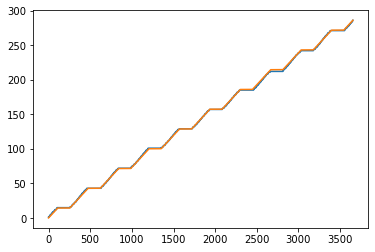

In [18]:
plt.plot(unights, result_sched)
plt.plot(unights,cumulative_desired )

In [19]:
# ok, now the way to iterate this should be pretty easy. 
# Find where chi^2 is most negative (the earliest index of it), then move that value to somewhere that is very positive
#

# Should be able to aneal this as well

In [20]:
result = basinhopping(min_object, x0, T=20 )

In [21]:
basin_sched = min_object.cumulative_sched(result.x)

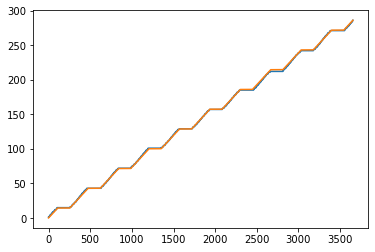

In [22]:
plt.plot(unights, basin_sched)
plt.plot(unights,cumulative_desired )

In [23]:
min_object(x0)

2.9712460063897765

In [24]:
min_object(result.x)

2.9712460063897765

In [25]:
# swapping to max abs deviation makes it stop iterating it looks like. 

In [26]:
result.x-x0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
x0[0]=20
x0[1] = 20
result = basinhopping(min_object, x0, T=50 )

In [28]:
result

                        fun: 3.9712460063897765
 lowest_optimization_result:       fun: 3.9712460063897765
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [29]:
min_object(result.x)

3.9712460063897765